# Setup

## Load trajectories

In [1]:
import pathlib
from pedpy import load_trajectory, TrajectoryUnit

folder = pathlib.Path("demos/uni-directional")
trajectories = {}
for file in folder.glob("uo*.txt"):
    trajectories[file.name] = load_trajectory(
        trajectory_file=file,
        default_frame_rate=16.0,
        default_unit=TrajectoryUnit.CENTIMETER,
    )

## Define geometry

In [2]:
from shapely import Polygon
from pedpy import Geometry

geometry = Geometry(
    walkable_area=Polygon(
        [
            (2.8, -6.5),
            (2.8, -4),
            (1.8, -4),
            (1.8, 4),
            (2.8, 4),
            (2.8, 8),
            (-1, 8),
            (-1, 4),
            (0, 4),
            (0, -4),
            (-1, -4),
            (-1, -6.5),
        ]
    )
)

## Define measurement areas and lines

In [3]:
from shapely import LineString

measurement_area = Polygon([(0, -2), (0, 0), (1.8, 0), (1.8, -2)])
measurement_line = LineString([(0, 0), (1.8, 0)])

## Plot trajectories, geometry, and measurement areas/lines

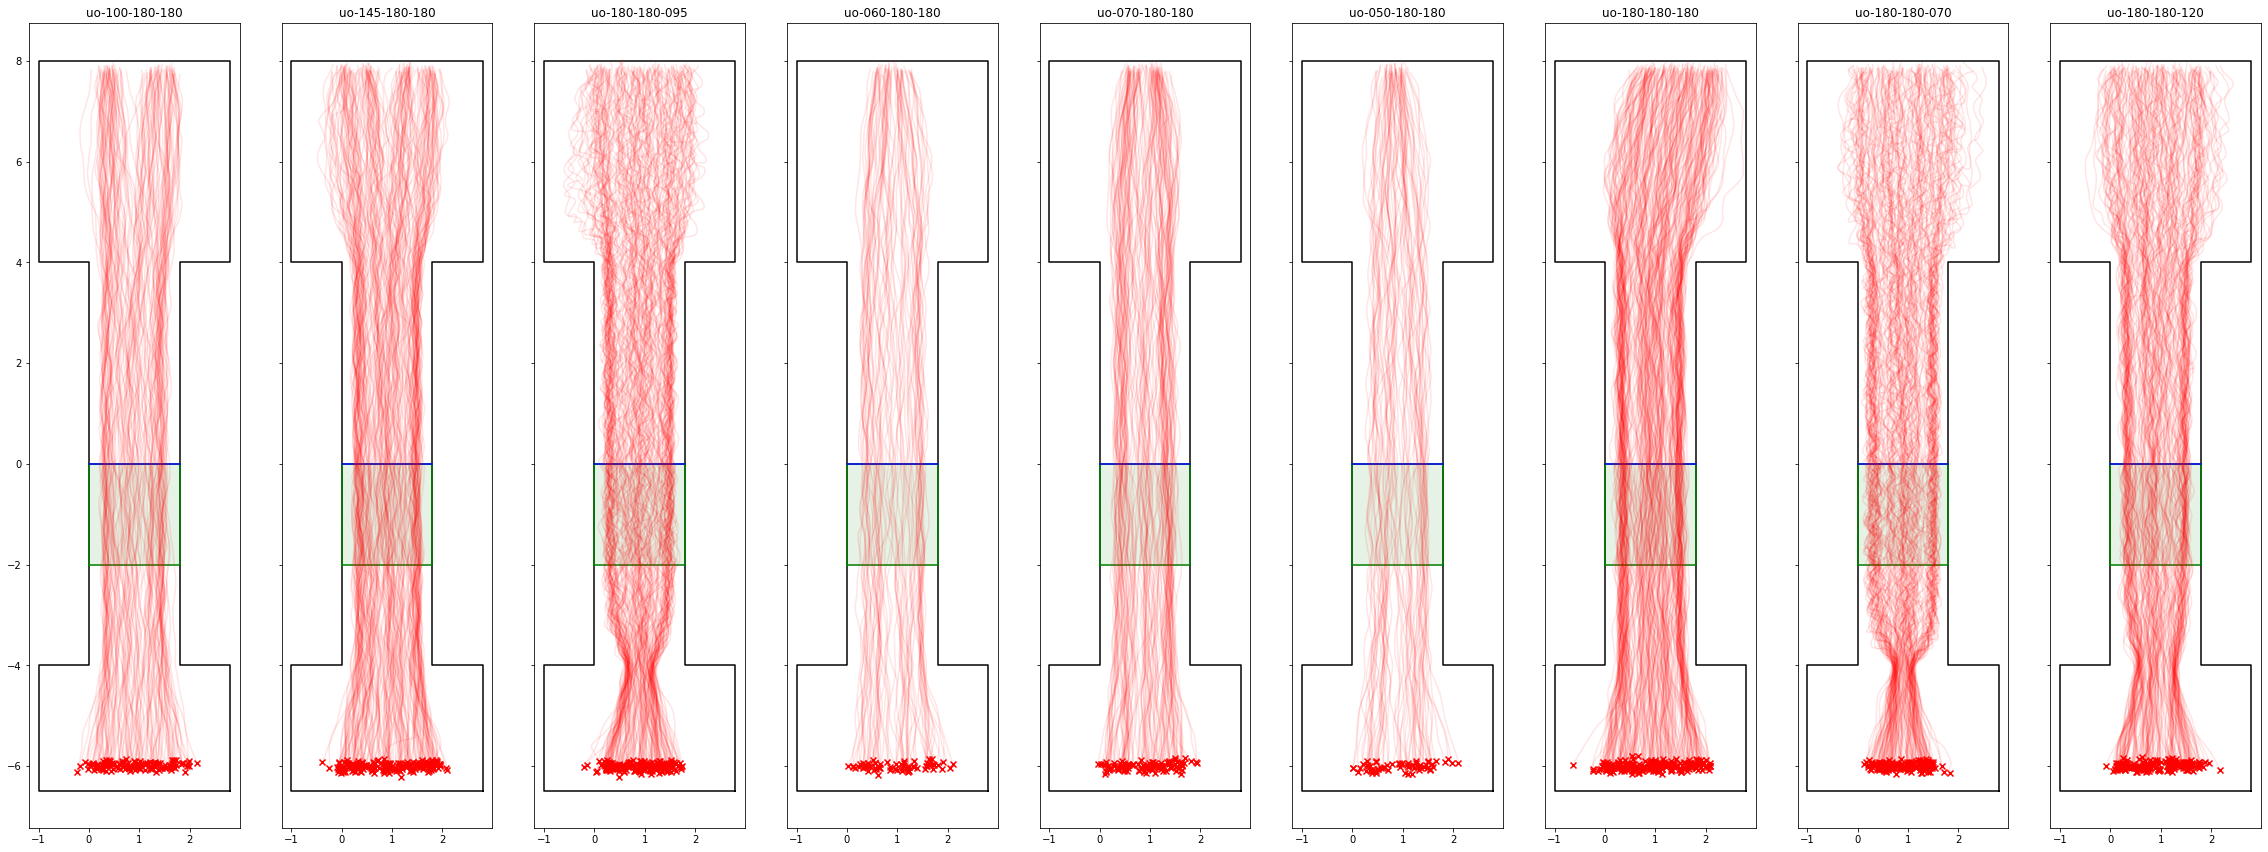

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(trajectories), figsize=(40, 40), sharey=True)

for (name, trajectory), ax in zip(trajectories.items(), axs):
    # ax = plt.subplot(111, aspect="equal")
    ax.set_title(name[:-4])

    # Plot geometry
    ax.plot(*geometry.walkable_area.exterior.xy, color="k")

    ## Plot measurement area
    ax.plot(*measurement_area.exterior.xy, color="g")
    ax.fill(*measurement_area.exterior.xy, color="g", alpha=0.1)

    ## Plot measurement lines
    ax.plot(*measurement_line.xy, color="b")

    # Plot trajectories
    for _, ped in trajectory.data.groupby("ID"):
        p = ax.plot(ped["X"], ped["Y"], label=id, alpha=0.1, color="r")
        ax.scatter(
            ped[ped.frame == ped.frame.max()]["X"],
            ped[ped.frame == ped.frame.max()]["Y"],
            c=p[-1].get_color(),
            marker="x",
        )
    ax.set_aspect("equal")
plt.show()

# Method A

## Compute n-t and flow

In [5]:
from pedpy import compute_n_t, compute_flow, compute_individual_velocity

nts = {}
flows = {}

for name, trajectory in trajectories.items():
    individual_speed = compute_individual_velocity(
        traj_data=trajectory.data,
        frame_rate=trajectory.frame_rate,
        frame_step=10,
    )

    nt, crossing = compute_n_t(
        traj_data=trajectory.data,
        measurement_line=measurement_line,
        frame_rate=trajectory.frame_rate,
    )

    delta_t = int(10 * trajectory.frame_rate)
    flow = compute_flow(
        nt=nt,
        crossing_frames=crossing,
        individual_speed=individual_speed,
        delta_t=delta_t,
        frame_rate=trajectory.frame_rate,
    )

    flows[name] = flow
    nts[name] = nt

## Plot n-t diagram

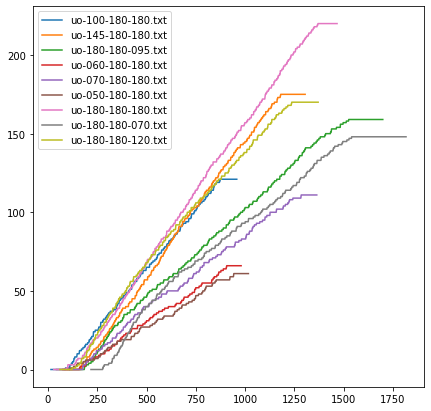

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(111)

for name, nt in nts.items():
    ax1.plot(nt.index, nt["Cumulative pedestrians"], label=name)

ax1.legend()
plt.show()

## Plot fundamental diagram

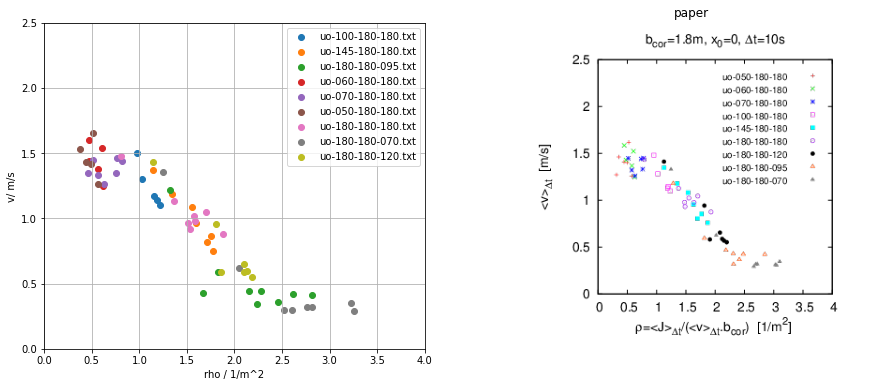

In [8]:
import matplotlib.pyplot as plt
from matplotlib import image as mpimg

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

for name, flow in flows.items():
    ax0.scatter(
        flow["Flow rate(1/s)"]
        / (flow["Mean velocity(m/s)"] * measurement_line.length),
        flow["Mean velocity(m/s)"],
        label=name,
    )


ax0.set_xlim(left=0, right=4)
ax0.set_ylim(bottom=0, top=2.5)

ax0.set_xlabel("rho / 1/m^2")
ax0.set_ylabel("v/ m/s")
ax0.grid()
ax0.legend()

img = mpimg.imread("demos/uni-directional/comparison/method_a_uo.png")
ax1.set_title("paper")
ax1.imshow(img)
ax1.axis("off")

plt.show()

# Method B

## Compute individual velocity and density while passing the measurement area

In [ ]:
from pedpy import (
    compute_passing_speed,
    compute_passing_density,
    compute_classic_density,
    compute_frame_range_in_area,
)

passing_densities = {}
passing_speeds = {}

for name, trajectory in trajectories.items():
    frames_in_area, passing_area = compute_frame_range_in_area(
        traj_data=trajectory.data, measurement_line=measurement_line, width=2
    )

    passing_speed = compute_passing_speed(
        frames_in_area=frames_in_area,
        frame_rate=trajectory.frame_rate,
        distance=2.0,
    )

    density_per_frame = compute_classic_density(
        traj_data=trajectory.data, measurement_area=passing_area
    )
    passing_density = compute_passing_density(
        density_per_frame=density_per_frame, frames=frames_in_area
    )

    passing_speeds[name] = passing_speed
    passing_densities[name] = passing_density

## Plot fundamental diagram

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import image as mpimg

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

for name in passing_speeds.keys():
    ax0.scatter(
        passing_densities[name]["density"],
        passing_speeds[name]["speed"],
        label=name,
    )
ax0.set_xlim(left=0, right=4)
ax0.set_ylim(bottom=0, top=2.5)

ax0.set_xlabel("rho / 1/m^2")
ax0.set_ylabel("v/ m/s")
ax0.grid()
ax0.legend()

img = mpimg.imread("demos/uni-directional/comparison/method_b_uo.png")
ax1.set_title("paper")
ax1.imshow(img)
ax1.axis("off")

plt.show()

# Method C

## Compute density and velocity

In [ ]:
from pedpy import compute_classic_density, compute_mean_velocity_per_frame

classic_densities = {}
mean_area_speeds = {}

for name, trajectory in trajectories.items():
    mean_area_speed, individual_speed_area = compute_mean_velocity_per_frame(
        traj_data=trajectory.data,
        measurement_area=measurement_area,
        frame_rate=trajectory.frame_rate,
        frame_step=5,
    )

    classic_density = compute_classic_density(
        traj_data=trajectory.data, measurement_area=measurement_area
    )

    classic_densities[name] = classic_density
    mean_area_speeds[name] = mean_area_speed

## Plot time series data

In [ ]:
fig, ax = plt.subplots(
    nrows=len(trajectories.values()), ncols=2, figsize=(20, 60)
)
row = 0

ax[row, 1].set_title("Velocity", size="xx-large")
ax[row, 0].set_title("Density", size="xx-large")

for name, trajectory in trajectories.items():
    ax[row, 0].annotate(
        name,
        xy=(0.5, 1),
        xytext=(-ax[row, 0].yaxis.labelpad - 5, 0),
        xycoords=ax[row, 0].yaxis.label,
        textcoords="offset points",
        size="xx-large",
        ha="right",
        va="center",
        rotation=90,
    )

    ax[row, 0].plot(
        classic_densities[name].index,
        classic_densities[name]["classic density"],
        alpha=1,
    )
    ax[row, 0].set_xlim(left=0)
    ax[row, 0].set_ylim(bottom=0, top=4)
    ax[row, 0].set_xlabel("frame")
    ax[row, 0].set_ylabel("rho / 1/m^2")
    ax[row, 0].grid()

    ax[row, 1].plot(
        mean_area_speeds[name].index, mean_area_speeds[name], alpha=1
    )
    ax[row, 1].set_xlim(
        left=0,
    )
    ax[row, 1].set_ylim(bottom=0, top=3)
    ax[row, 1].set_xlabel("frame")
    ax[row, 1].set_ylabel("v / m/s")
    ax[row, 1].grid()

    row += 1

## Plot fundamental diagram

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import image as mpimg

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

ax0.set_title("Fundamental Diagram")

for name in classic_densities.keys():
    ax0.scatter(
        classic_densities[name]["classic density"],
        mean_area_speeds[name],
        alpha=1,
        marker="x",
        label=name,
    )
ax0.set_xlim(left=0, right=4)
ax0.set_ylim(bottom=0, top=2.5)

ax0.set_xlabel("rho / 1/m^2")
ax0.set_ylabel("v/ m/s")
ax0.grid()
ax0.legend()

img = mpimg.imread("demos/uni-directional/comparison/method_c_uo.png")
ax1.set_title("paper")
ax1.imshow(img)
ax1.axis("off")
Vplt.show()

# Method D

## Compute density and velocity

### Without cutoff radius

In [ ]:
from pedpy import compute_voronoi_velocity, compute_voronoi_density

voronoi_densities = {}
voronoi_velocities = {}
individual_velocities = {}
individuals = {}

for name, trajectory in trajectories.items():
    voronoi_density, individual = compute_voronoi_density(
        traj_data=trajectory.data,
        measurement_area=measurement_area,
        geometry=geometry,
    )

    voronoi_velocity, individual_velocity = compute_voronoi_velocity(
        traj_data=trajectory.data,
        individual_voronoi_intersection=individual,
        frame_rate=trajectory.frame_rate,
        frame_step=5,
        measurement_area=measurement_area,
    )

    voronoi_densities[name] = voronoi_density
    voronoi_velocities[name] = voronoi_velocity
    individual_velocities[name] = individual_velocity
    individuals[name] = individual

### With cutoff radius

In [ ]:
from pedpy import compute_voronoi_velocity, compute_voronoi_density

voronoi_densities_cutoff = {}
voronoi_velocities_cutoff = {}
individual_velocities_cutoff = {}
individual_cutoffs = {}
for name, trajectory in trajectories.items():

    voronoi_density_cutoff, individual_cutoff = compute_voronoi_density(
        traj_data=trajectory.data,
        measurement_area=measurement_area,
        geometry=geometry,
        cut_off=(0.8, 12),
    )

    (
        voronoi_velocity_cutoff,
        individual_velocity_cutoff,
    ) = compute_voronoi_velocity(
        traj_data=trajectory.data,
        individual_voronoi_intersection=individual_cutoff,
        frame_rate=trajectory.frame_rate,
        frame_step=5,
        measurement_area=measurement_area,
    )

    voronoi_densities_cutoff[name] = voronoi_density_cutoff
    voronoi_velocities_cutoff[name] = voronoi_velocity_cutoff
    individual_velocities_cutoff[name] = individual_velocity_cutoff
    individual_cutoffs[name] = individual_cutoff

## Plot time-series data

In [ ]:
fig, ax = plt.subplots(
    nrows=len(trajectories.values()), ncols=2, figsize=(20, 60)
)
row = 0

ax[row, 1].set_title("Velocity", size="xx-large")
ax[row, 0].set_title("Density", size="xx-large")

for name, trajectory in trajectories.items():
    ax[row, 0].annotate(
        name,
        xy=(0.5, 1),
        xytext=(-ax[row, 0].yaxis.labelpad - 5, 0),
        xycoords=ax[row, 0].yaxis.label,
        textcoords="offset points",
        size="xx-large",
        ha="right",
        va="center",
        rotation=90,
    )

    ax[row, 0].plot(
        voronoi_densities[name].index,
        voronoi_densities[name]["voronoi density"],
        alpha=1,
        label="without cut-off",
    )
    ax[row, 0].plot(
        voronoi_densities_cutoff[name].index,
        voronoi_densities_cutoff[name]["voronoi density"],
        alpha=1,
        label="with cut-off",
    )
    ax[row, 0].set_xlim(left=0)
    ax[row, 0].set_ylim(bottom=0, top=4)
    ax[row, 0].set_xlabel("frame")
    ax[row, 0].set_ylabel("rho / 1/m^2")
    ax[row, 0].grid()
    ax[row, 0].legend()

    ax[row, 1].plot(
        voronoi_velocities[name].index,
        voronoi_velocities[name],
        alpha=1,
        label="without cut-off",
    )
    ax[row, 1].plot(
        voronoi_velocities_cutoff[name].index,
        voronoi_velocities_cutoff[name],
        alpha=1,
        label="with cut-off",
    )
    ax[row, 1].set_xlim(
        left=0,
    )
    ax[row, 1].set_ylim(bottom=0, top=3)
    ax[row, 1].set_xlabel("frame")
    ax[row, 1].set_ylabel("v / m/s")
    ax[row, 1].grid()
    ax[row, 1].legend()
    row += 1
plt.show()

## Plot fundamental diagram

In [ ]:
from matplotlib import image as mpimg
import matplotlib.pyplot as plt

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
fig.suptitle("Fundamental diagram")

ax0.set_title("without cutoff")
for name in voronoi_densities.keys():
    ax0.scatter(
        voronoi_densities[name]["voronoi density"],
        voronoi_velocities[name],
        alpha=1,
        marker="x",
        label=name,
    )
ax0.set_xlim(left=0, right=4)
ax0.set_ylim(bottom=0, top=2.5)

ax0.set_xlabel("rho / 1/m^2")
ax0.set_ylabel("v/ m/s")
ax0.grid()
ax0.legend()

ax1.set_title("with cutoff")
for name in voronoi_densities_cutoff.keys():
    ax1.scatter(
        voronoi_densities_cutoff[name]["voronoi density"],
        voronoi_velocities_cutoff[name],
        alpha=1,
        marker="x",
        label=name,
    )
ax1.set_xlim(left=0, right=4)
ax1.set_ylim(bottom=0, top=2.5)

ax1.set_xlabel("rho / 1/m^2")
ax1.set_ylabel("v/ m/s")
ax1.grid()
ax1.legend()

img = mpimg.imread("demos/uni-directional/comparison/method_d_uo.png")
ax2.set_title("paper")
ax2.imshow(img)
ax2.axis("off")
plt.show()

# Profiles

## Compute velocity and density profiles

In [ ]:
import pandas as pd

from pedpy import (
    compute_profiles,
    VelocityMethod,
    compute_voronoi_velocity,
    compute_voronoi_density,
)

trajectory = list(trajectories.values())[7]

frames_data = trajectory.data[trajectory.data.frame.between(750, 1500)]

voronoi_density_frames, individual_frames = compute_voronoi_density(
    traj_data=frames_data,
    measurement_area=measurement_area,
    geometry=geometry,
    cut_off=(0.89, 12),
)
voronoi_velocity_frames, individual_velocity_frames = compute_voronoi_velocity(
    traj_data=trajectory.data,
    individual_voronoi_intersection=individual_frames,
    frame_rate=trajectory.frame_rate,
    frame_step=5,
    measurement_area=measurement_area,
)

density_profiles, velocity_profiles = compute_profiles(
    individual_voronoi_velocity_data=pd.merge(
        individual_frames,
        individual_velocity_frames,
        on=["ID", "frame"],
        how="left",
    ),
    walkable_area=geometry.walkable_area,
    grid_size=0.25,
    velocity_method=VelocityMethod.VORONOI,
)

## Plot profiles

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

bounds = geometry.walkable_area.bounds

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

ax0.set_title("Density")
cm = ax0.imshow(
    np.mean(density_profiles, axis=0),
    extent=[bounds[0], bounds[2], bounds[1], bounds[3]],
    interpolation="None",
    cmap="jet",
    vmin=0,
    vmax=5,
)
fig.colorbar(cm, ax=ax0, shrink=0.3)
ax0.plot(*geometry.walkable_area.exterior.xy, color="w")

ax1.set_title("Velocity")
cm = ax1.imshow(
    np.mean(velocity_profiles, axis=0),
    extent=[bounds[0], bounds[2], bounds[1], bounds[3]],
    interpolation="None",
    cmap="jet",
    vmin=0,
    vmax=1.5,
)
fig.colorbar(cm, ax=ax1, shrink=0.3)

ax1.plot(*geometry.walkable_area.exterior.xy, color="w")

fig.tight_layout()

# Plots

### Plot Voronoi cells

In [ ]:
import shapely
import matplotlib.pyplot as plt
import matplotlib as mpl

import pandas as pd
from enum import Enum


class ColorMode(Enum):
    Velocity = 1
    Density = 2


# Choose trajectory file to plot
name = list(trajectories.keys())[6]

# Choose frame to plot
frame = 700

# Choose which color mode used to display the voronoi cells. Can be Velocity or Density
color_mode = ColorMode.Velocity

# Choose which voronoi data to plot
use_cut_off_data = True

# merge all relevant data into one data frame
voronoi_data = (
    individual_cutoffs[name] if use_cut_off_data else individuals[name]
)
velocity_data = (
    individual_velocities_cutoff[name][["ID", "frame", "speed"]]
    if use_cut_off_data
    else individual_velocities[name][["ID", "frame", "speed"]]
)
all_data = pd.merge(
    trajectories[name].data, voronoi_data, on=["ID", "frame"]
).merge(velocity_data, on=["ID", "frame"])
# data = all_data
data = all_data[all_data.frame == frame]

# Start plotting
fig = plt.figure(figsize=(15, 20))
fig.suptitle(name)
ax1 = fig.add_subplot(111, aspect="equal")

# Plot geometry
ax1.plot(*geometry.walkable_area.exterior.xy, color="k")

# Plot measurement area
ax1.plot(*measurement_area.exterior.xy, color="g")

# Create color mapping for velocity/density to color
my_cmap = plt.get_cmap("jet")
norm = mpl.colors.Normalize(
    vmin=0, vmax=4 if color_mode == ColorMode.Velocity else 8
)
scalar_mappable = mpl.cm.ScalarMappable(norm=norm, cmap=my_cmap)

# Plot voronoi cells
for id, ped in data.groupby("ID"):
    poly = ped["individual voronoi"].values[0]
    color = "gray"
    ax1.plot(*poly.exterior.xy, alpha=0.2, color=color)
    ax1.fill(*poly.exterior.xy, fc=color, alpha=0.1)

    sc = ax1.scatter(ped["X"], ped["Y"], c=color, alpha=0.5)

    if not shapely.is_empty(ped["intersection voronoi"].iat[0]):
        poly = ped["intersection voronoi"].values[0]
        color = (
            scalar_mappable.to_rgba(ped["speed"])
            if color_mode == ColorMode.Velocity
            else scalar_mappable.to_rgba(1 / poly.area)
        )
        ax1.plot(*poly.exterior.xy, alpha=0.5, color=color)
        ax1.fill(*poly.exterior.xy, fc=color, alpha=0.4)

fig.colorbar(
    scalar_mappable,
    label="v / m/s" if color_mode == ColorMode.Velocity else "rho / 1/m^2",
    ax=plt.gca(),
    shrink=0.4,
    location="right",
)
plt.show()